# Assignment 3

First, we will import all the files and use it for downsampling:


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

# we won't use these packages directly, but the function that picks colors will
import scipy
import scipy.misc
import scipy.cluster

# If you haven't yet, you may need to install scipy
#!conda install -c anaconda scipy


# NOTE: I am not expecting you to know how to write these on your own!
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# Importing 1st image: 

In [2]:
image1 = Image.open("/Users/patil/Downloads/images.jpeg")

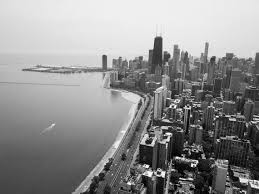

In [3]:
image1

Convert to an 8-color image for easier handling:

In [4]:
new_im1, new_rgbs1 = convert_image(image1, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[124.94708129 124.94708129 124.94708129]
 [233.27397521 233.27397521 233.27397521]
 [ 29.81607178  29.81607178  29.81607178]
 [157.38478885 157.38478885 157.38478885]
 [ 67.87711617  67.87711617  67.87711617]
 [ 94.75570685  94.75570685  94.75570685]
 [215.63164085 215.63164085 215.63164085]
 [186.67886855 186.67886855 186.67886855]]


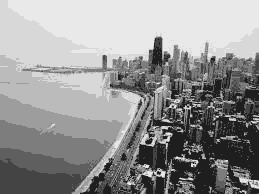

In [5]:
new_im1

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [6]:
new_im_data1 = np.array(new_im1)

In [7]:
np.unique(new_im_data1.reshape(-1, new_im_data1.shape[2]), axis=0)

array([[ 30,  30,  30],
       [ 68,  68,  68],
       [ 95,  95,  95],
       [125, 125, 125],
       [157, 157, 157],
       [187, 187, 187],
       [216, 216, 216],
       [233, 233, 233]], dtype=uint8)

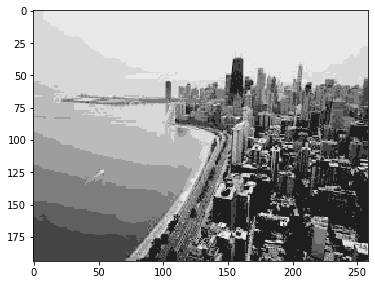

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(new_im_data1)
plt.show()

We will now make a histogram of all the colors using preprocessing techniques:

In [9]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [10]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [11]:
unique_colors = np.unique(new_im_data1.reshape(-1, new_im_data1.shape[2]), axis=0)
unique_colors

array([[ 30,  30,  30],
       [ 68,  68,  68],
       [ 95,  95,  95],
       [125, 125, 125],
       [157, 157, 157],
       [187, 187, 187],
       [216, 216, 216],
       [233, 233, 233]], dtype=uint8)

In [12]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data1[:,:,0] == rgb[0] 
    greens_mask = new_im_data1[:,:,1] == rgb[1]
    blues_mask = new_im_data1[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data1[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

In [13]:
color_labels

['Color #0',
 'Color #1',
 'Color #2',
 'Color #3',
 'Color #4',
 'Color #5',
 'Color #6',
 'Color #7']

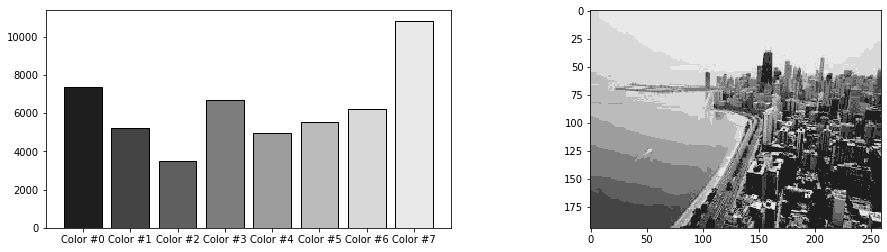

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data1)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

# Importing 2nd image:

In [15]:
image2 = Image.open("/Users/patil/Downloads/Chicagoday.png")

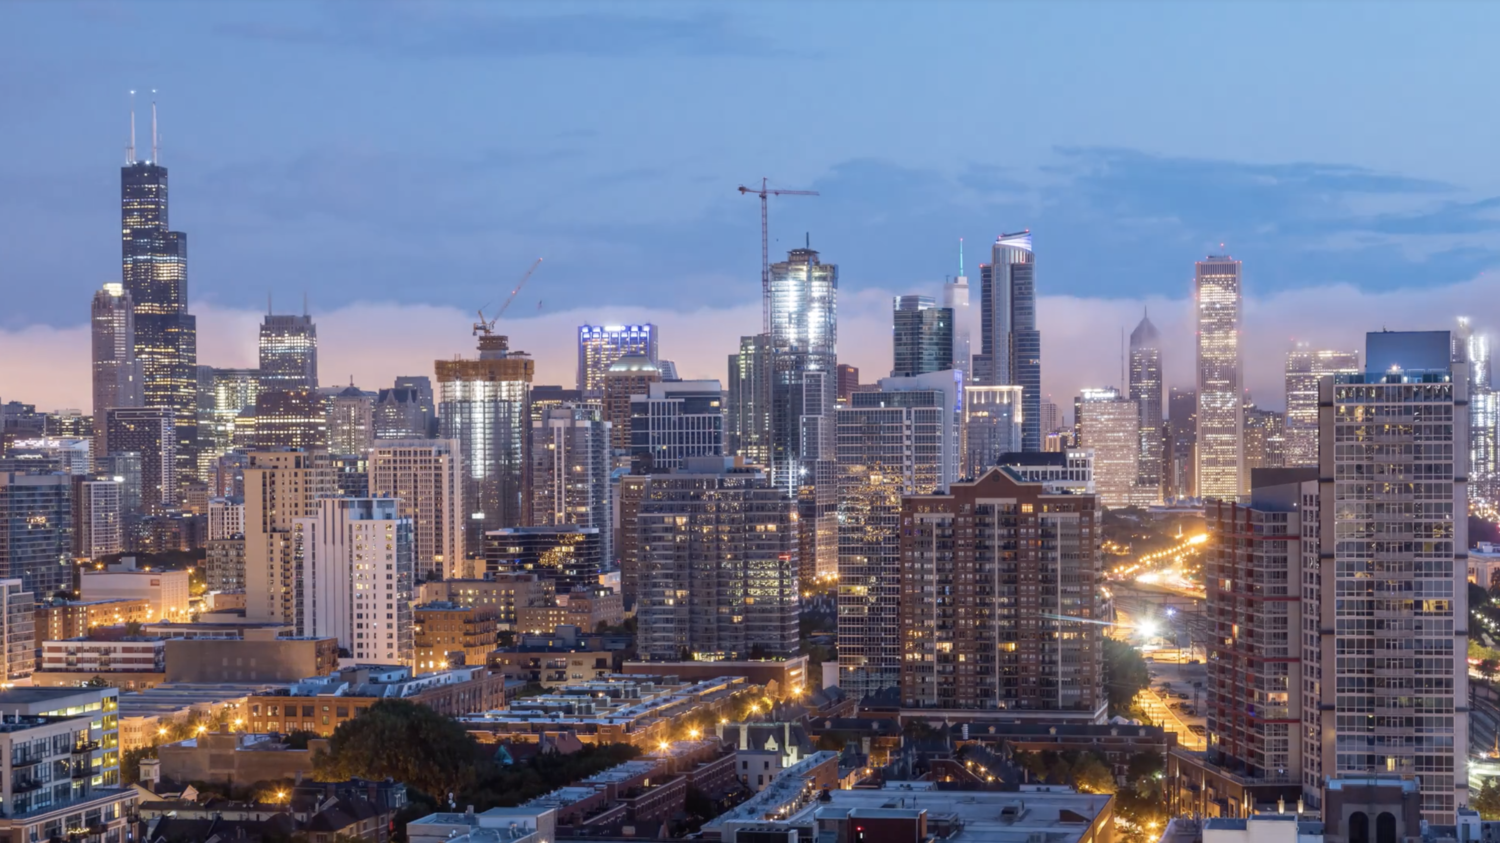

In [16]:
image2

Convert to an 8-color image for easier handling:

In [18]:
new_im2, new_rgbs2 = convert_image(image2, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 37.705583    30.93600791  41.40543478]
 [ 69.84725123  59.35357112  71.50104969]
 [122.12118787 110.91840559 122.43303643]
 [138.12700416 173.88628025 218.08716775]
 [170.0194703  143.60961599 133.43929583]
 [198.08265563 184.92610849 192.20703385]
 [120.22673431 153.80051771 204.43420998]
 [ 94.40224503  84.2001296   96.71317335]]


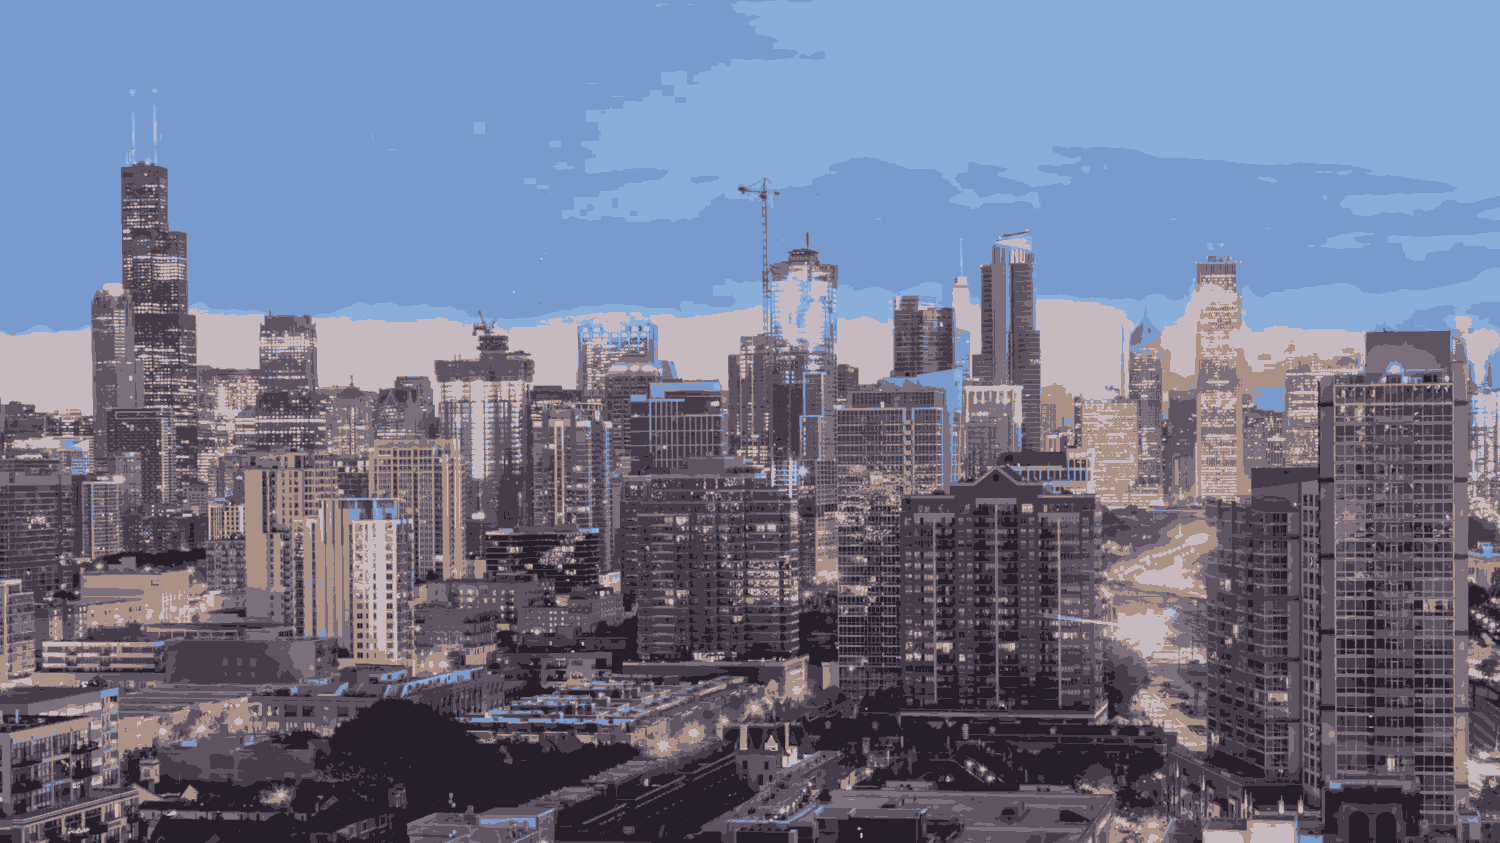

In [19]:
new_im2

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [20]:
new_im_data2 = np.array(new_im2)

In [21]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [22]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [23]:
unique_colors = np.unique(new_im_data2.reshape(-1, new_im_data2.shape[2]), axis=0)
unique_colors

array([[ 38,  31,  41],
       [ 70,  59,  72],
       [ 94,  84,  97],
       [120, 154, 204],
       [122, 111, 122],
       [138, 174, 218],
       [170, 144, 133],
       [198, 185, 192]], dtype=uint8)

In [24]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data2[:,:,0] == rgb[0] 
    greens_mask = new_im_data2[:,:,1] == rgb[1]
    blues_mask = new_im_data2[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data2[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

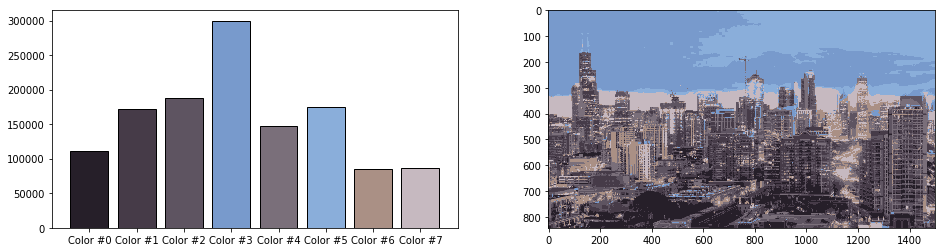

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data2)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

# Importing 3rd image:

In [26]:
image3 = Image.open("/Users/patil/Downloads/Chicagonight.jpg")

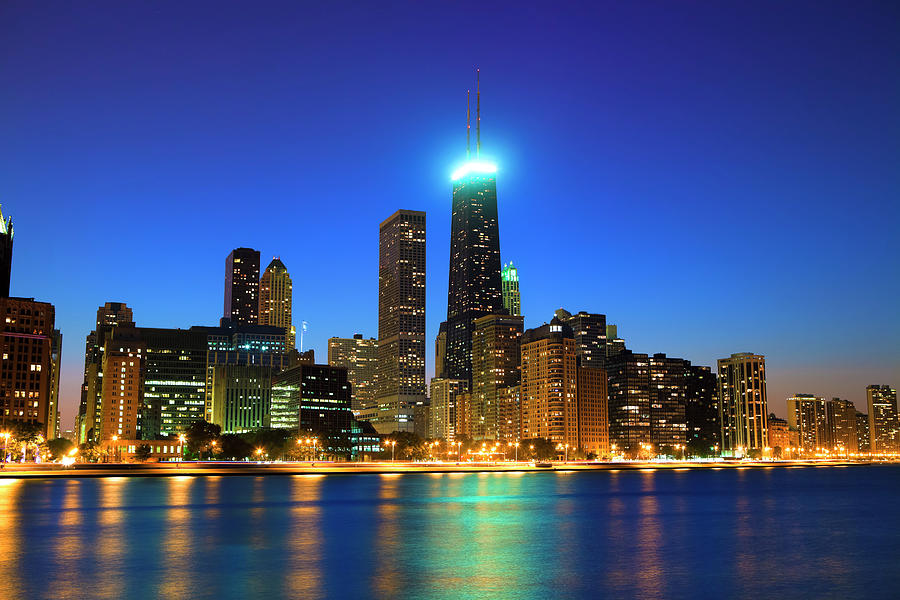

In [27]:
image3

Convert to an 8-color image for easier handling:

In [28]:
new_im3, new_rgbs1 = convert_image(image3, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 61.27396521 128.1849989  234.42522757]
 [183.77701902 207.1946697  164.01783089]
 [ 50.14569811  89.24650888 187.24112197]
 [ 36.55615597  26.783695    16.76664486]
 [205.25272062 136.74318192  51.00431775]
 [ 35.11128713  51.76258526  89.36279428]
 [109.94771032  89.11851877  59.52303216]
 [ 41.78780542  54.64953475 144.1137979 ]]


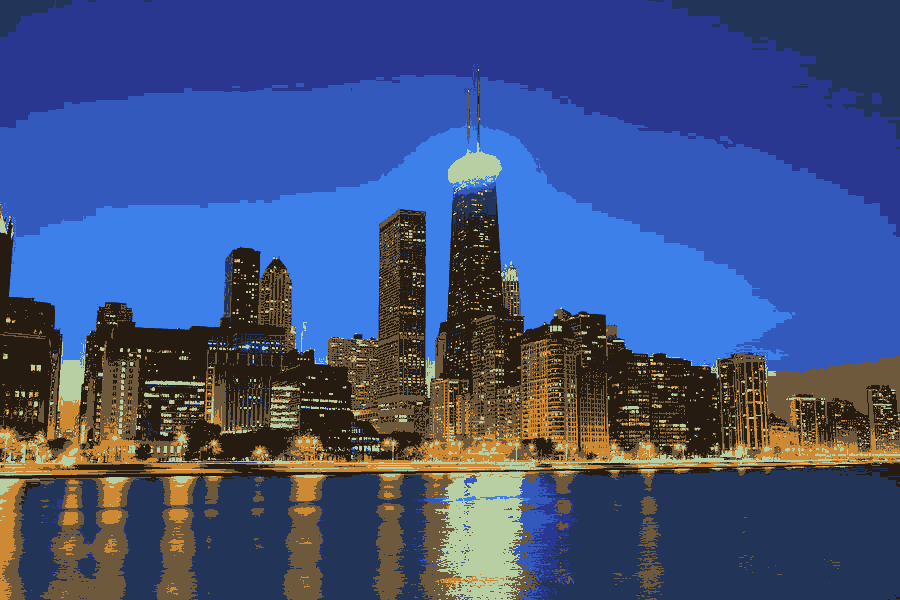

In [29]:
new_im3

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [30]:
new_im_data3 = np.array(new_im3)

In [31]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [32]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [33]:
unique_colors = np.unique(new_im_data3.reshape(-1, new_im_data3.shape[2]), axis=0)
unique_colors

array([[ 35,  52,  89],
       [ 37,  27,  17],
       [ 42,  55, 144],
       [ 50,  89, 187],
       [ 61, 128, 234],
       [110,  89,  60],
       [184, 207, 164],
       [205, 137,  51]], dtype=uint8)

In [34]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data3[:,:,0] == rgb[0] 
    greens_mask = new_im_data3[:,:,1] == rgb[1]
    blues_mask = new_im_data3[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data3[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

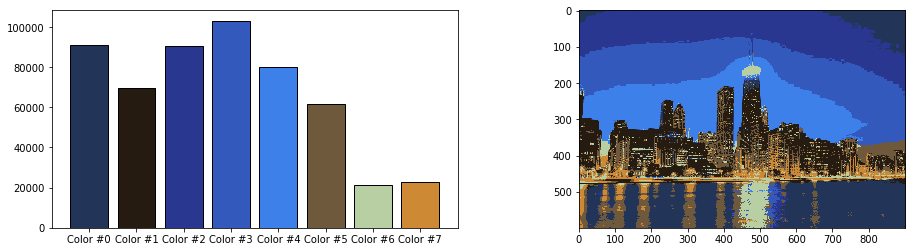

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data3)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

# Converting all images to same color sequence for better comparison


Image 1:

In [36]:
new_im11, new_rgbs11 = convert_image_specific(image1, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

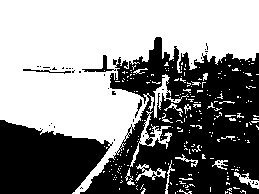

In [37]:
new_im11

In [38]:
new_im_data11 = np.array(new_im11)

In [39]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [40]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [41]:
unique_colors = np.unique(new_im_data11.reshape(-1, new_im_data11.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [42]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data11[:,:,0] == rgb[0] 
    greens_mask = new_im_data11[:,:,1] == rgb[1]
    blues_mask = new_im_data11[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data11[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

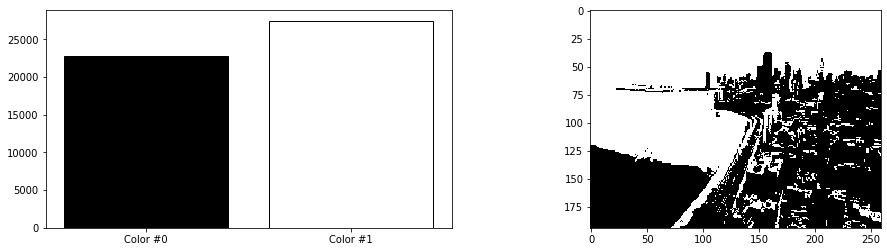

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data11)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

Image 2:

In [44]:
new_im22, new_rgbs22 = convert_image_specific(image2, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

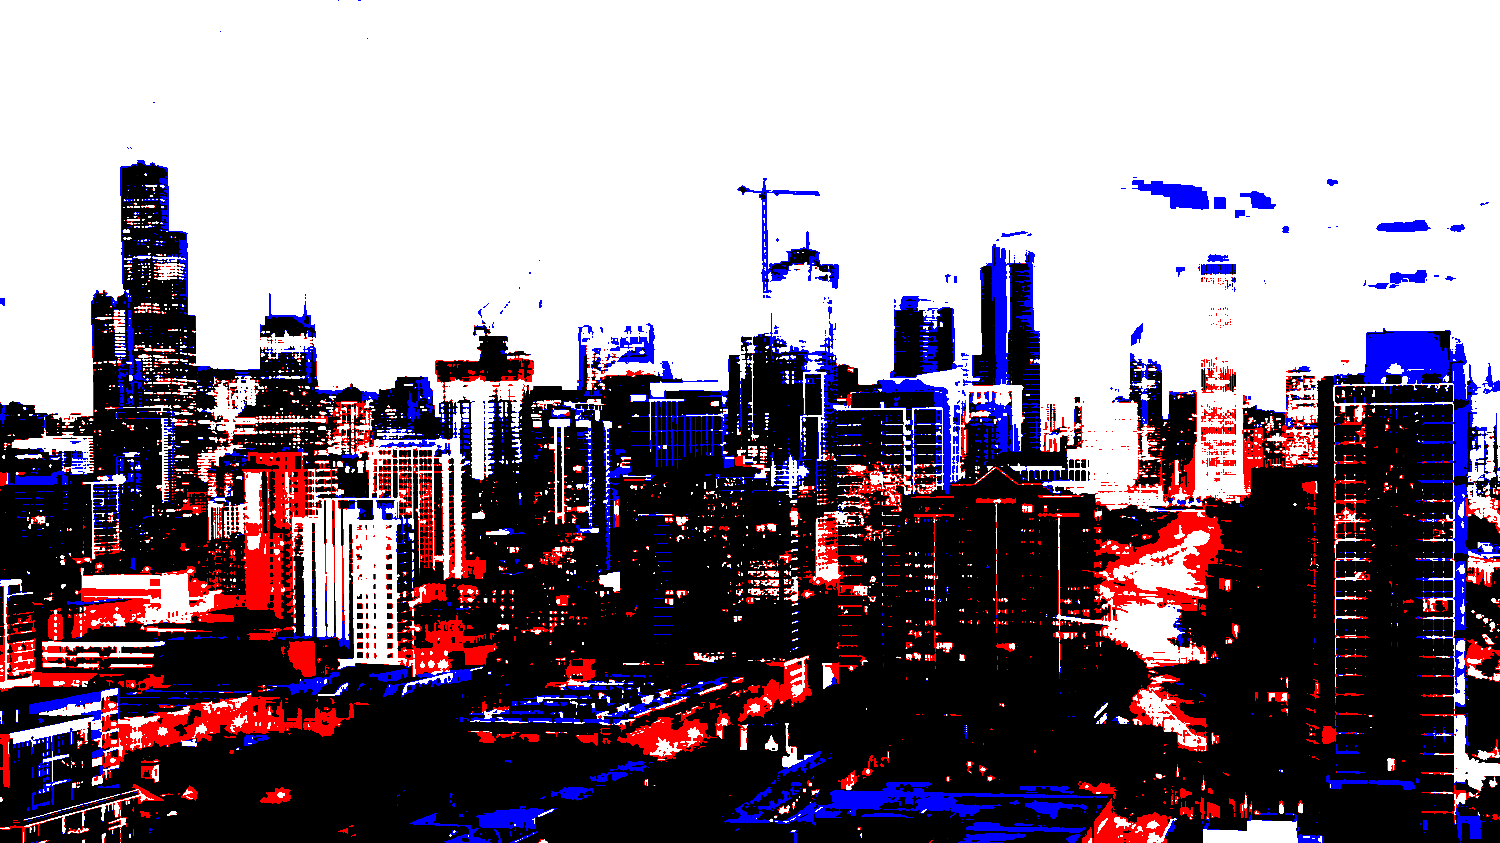

In [45]:
new_im22

In [46]:
new_im_data22 = np.array(new_im22)

In [47]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [48]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [49]:
unique_colors = np.unique(new_im_data22.reshape(-1, new_im_data22.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [  0,   0, 255],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [50]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data22[:,:,0] == rgb[0] 
    greens_mask = new_im_data22[:,:,1] == rgb[1]
    blues_mask = new_im_data22[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data22[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

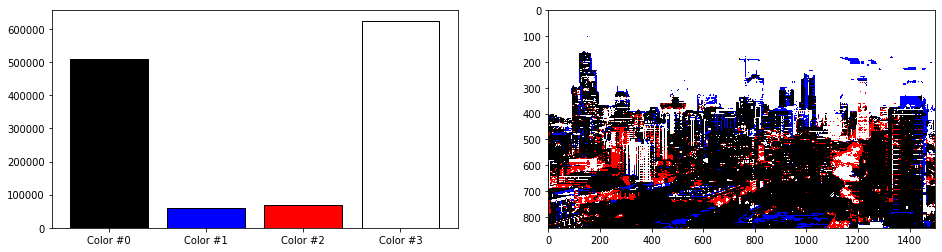

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data22)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

Image 3:

In [52]:
new_im33, new_rgbs33 = convert_image_specific(image3, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

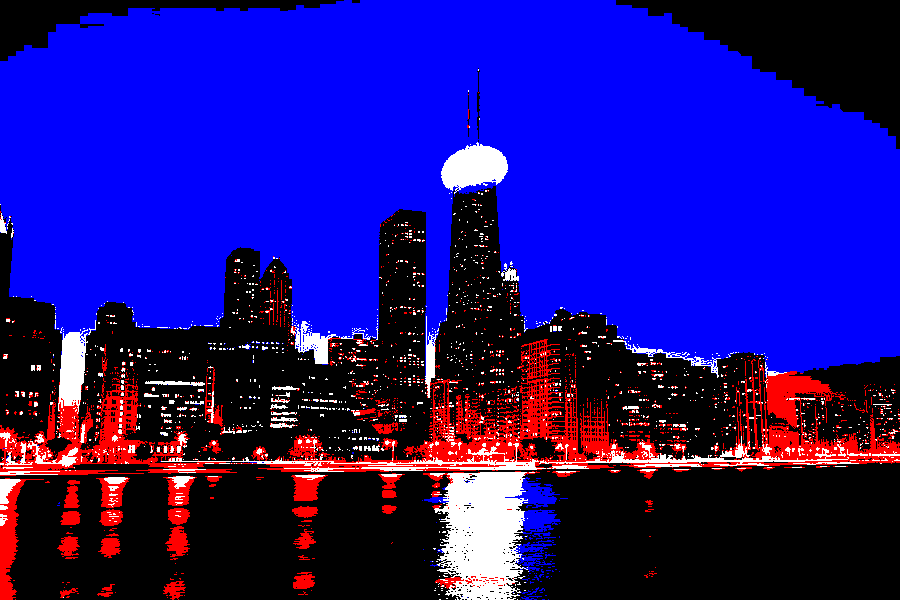

In [53]:
new_im33

In [54]:
new_im_data33 = np.array(new_im33)

In [55]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [56]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [57]:
unique_colors = np.unique(new_im_data33.reshape(-1, new_im_data33.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [  0,   0, 255],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [58]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data33[:,:,0] == rgb[0] 
    greens_mask = new_im_data33[:,:,1] == rgb[1]
    blues_mask = new_im_data33[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data33[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

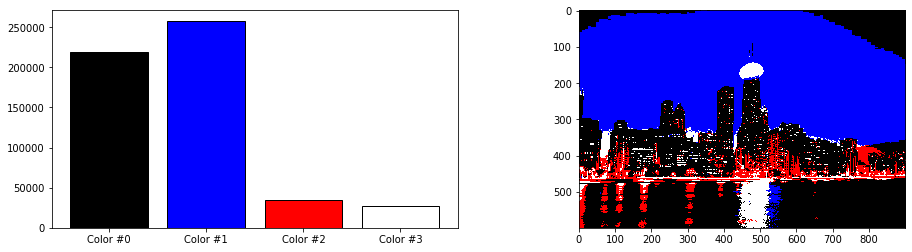

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data33)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()